# Group information

Names and RAs:

- Guilherme Webster Chamoun 257111

- Vinicius Forato Coracin 231528

## Objective:

To explore **Transfer Learning** techniques, focused on **Transformers**. In this task you'll be visualizing and fine tunning a pre trained transformer to a Natural Language Processing task, specifically, binary sentiment classification.

This **MUST** be developed using the pytorch and the [Hugging Face](https://huggingface.co/) library.

## Dataset

The dataset you will use is the "Large Movie Review Dataset", also known as IMDB dataset. This dataset contains 50000 movie reviews, with positive or negative labels. The dataset is balanced, and the train and test sets are already separated in a disjointed way, to avoid movies being in both datasets (as reviews in the same movies tend to be similar).

The labels are constructed using the ratings of the review, where a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. "Neutral" reviews (score 5 or 6) were ignored, as they cannot be correctly labeled between negative and positive samples.


The dataset will be available in the [same folder](https://drive.google.com/drive/folders/14uiy_7xMq5LOqODBzbIJLD4Vq0E9XD5v) as the other tasks, in the "aclImdb" folder. You can copy the dataset folder or download it locally.

Here are some examples of each class from the dataset:

**Negative**

`Lifetime did it again. Can we say stupid? I couldn't wait for it to end. The plot was senseless. The acting was terrible! Especially by the teenagers. The story has been played a thousand times! Are we just desperate to give actors a job? The previews were attractive and I was really looking for a good thriller.Once in awhile lifetime comes up with a good movie, this isn't one of them. Unless one has nothing else to do I would avoid this one at all cost. This was a waste of two hours of my life. Can I get them back? I would have rather scraped my face against a brick wall for two hours then soaked it in peroxide. That would have been more entertaining.`

**Positive**

`Generally it was a good movie with an ideal ending; the acting was spectacular and the characters didn't stray from their persons. I especially liked the plot, although you knew what was going to happen it still gave the element of surprise through out the entire movie. However, I find that coming on to the ending it could have been a little longer (extended maybe)- to me it seemed like it was rushed a bit; as if the writer was trying to take linens off the lines before the rain fell. For instance- What happened to Tristan's brother, Hayden? For all we know he died in the hospital. Maybe he was the one that setup the entire thing?! Who knows! Maybe there will be a sequel? Maybe? If there is.. I cant wait to see it.`


As in the previous task, in this task the data analysis will not be required. Again, its important to remember that the data analysis is a constant and important part of the machine learning pipeline, and we are just skipping it because this task has educational purposes only.

## Loading the dataset

The code below is already completed to load the dataset separating it in train, validation and test.

In [ ]:
import os
import random
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from transformers import BertTokenizerFast, BertForSequenceClassification

In [ ]:
# Define dataset path

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# set path to the folder that contains the aclImdb dataset
path = "gdrive/MyDrive/MC886 - Datasets/"

Mounted at /content/gdrive


In [ ]:
# this separates 20k for training, 5k for validation and 25k for testing

max_valid = 5000

def load_texts(folder):
  texts = []
  for path in os.listdir(folder):
    with open(os.path.join(folder, path)) as f:
      texts.append(f.read())
  return texts

x_train_pos = load_texts(path + 'aclImdb/train/pos')
x_train_neg = load_texts(path + 'aclImdb/train/neg')
x_test_pos  = load_texts(path + 'aclImdb/test/pos')
x_test_neg  = load_texts(path + 'aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test  = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test  = [True] * len(x_test_pos)  + [False] * len(x_test_neg)

c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print('\nFirst two train samples:')
for i, (source, target) in enumerate(zip(x_train[:2], y_train[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print('\nFirst two valid samples:')
for i, (source, target) in enumerate(zip(x_valid[:2], y_valid[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First two train samples:
0: Input: Gung Ho tries to express many ideas and entertain us with a wiseguy comedy at the same time. The result is uneven, but generally entertaining. Keaton balances all three aspects of his lead character quite well. Wantabedde is even better. One warning: George Wendt is very poor in his supporting role. Otherwise, this is quite enjoyable time capsule.
   Target: positive

1: Input: My, Kasi Lemmings certainly is a fair looking woman. This film is a lost gem, a dead-on satire "mockumentary" of the early 90's Hip Hop scene, when MC Hammer had just began to fade away into that good night. We follow the three members of the NWH as they embark upon their picaresque journey of would-be riches and fame. And like Nickolas Nickleby, at the end, they finish their journey not far from where they started, but at least a little wiser and lot less naive. This is one of the best films that no one has ever heard of, but it's the kind of film you either love or hate, a l

## Loading the pre trained transformer

The code below loads a pre trained transformer from hugging face library.
The **recommended** model is the BERT-Mini, that is a smaller version of the BERT transformer.

You can choose other transformers to test, but the BERT-Mini was choosed to reduce the fine tunning time, while also having a powerfull structure.

The image below shows the normal BERT architecture scheme and the BERT-Large. In the same way, the BERT-Mini has only four attention heads (instead of the original 12).

![BERTS](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)

The BERT variations also are related to amount of hidden embedding sizes.
Some variations are:

- google/bert_uncased_L-2_H-128_A-2 (BERT-Tiny, 4M params)
- google/bert_uncased_L-4_H-256_A-4 (BERT-Mini, 11M params)
- google/bert_uncased_L-4_H-512_A-4 (BERT-Small, 29M params)
- google/bert_uncased_L-8_H-512_A-8 (BERT-Medium, 41M params)
- google/bert_uncased_L-12_H-768_A-12 (BERT-Base, 110M params)

You can find more details about miniature BERT versions [here](https://huggingface.co/google/bert_uncased_L-4_H-256_A-4).


## Parameters

In [ ]:
params = {
    'bert_version': "google/bert_uncased_L-4_H-256_A-4",
    'batch_size': 64,
    'learning_rate': 1e-5, # Choose a learning rate between 1e-4 and 1e-7
    'weight_decay': 0.01,  # Choose a value between 1e-2 and 1e-4.
    'max_length': 100,     # The maximum length of the sentence (can be adjusted)
    'epochs': 5,           # Choose a value between 1 and 5
}

## Tokenizer

To use text as input for a deep learning model, we first need to tokenize each sentence based on a set of rules. After tokenization, each token is assigned a correlated index, creating a feature vector. This vector is then utilized by the model to train and update the weights. Here is an example demonstrating how the BERT tokenizer works:

Initially, the input sentence is divided into tokens predetermined by the BERT tokenizer. Next, the BertTokenizer introduces two special tokens: CLS and SEP. CLS represents sentence start for tasks like classification, while SEP indicates sentence separation for boundary detection within a document. Additionally, to ensure sentences are of equal length, the tokenizer employ the PAD token for each input.

Finally, each token is converted into a predetermined index for BERT input. This indexing enables the Bert model to train and update its weights effectively.

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index]
        return item

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test),  truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

## Load the transformer


In [ ]:
#defining device where to to the computation
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(params['bert_version'])
model = model.to(device)


pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dimentionality reduction and visualization tranformer embeddings (2.0 points)

In this section, you should use PCA and t-SNE to visualize the embeddings produced by the transformer for a batch of the aclImdb dataset.

In [ ]:
# Function to visualize the embeddings

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, dim_reducer):
  '''
  'hidden_states' are the activations of the hidden layers for a batch
    (use the '.hidden_states' attribute from the transformer's output with 'output_hidden_states=True');
  'masks' are the attention masks of each sample (the dataloader returns a dict with the "attention_masks" key);
  'labels' are the labels of the batch;
  'layers_to_visualize' is an array of indexes to look on 'hidden_states';
  'dim_reducer' is a function to reduce the dimentionality of the hidden states (should be PCA or t-SNE object).
  '''
  num_layers = len(layers_to_visualize)

  fig = plt.figure(figsize=(24,int((num_layers/4)*6))) # each subplot of size 6x6, each row will hold 4 plots
  ax = [fig.add_subplot(num_layers//4+1,4,i+1) for i in range(num_layers)]

  labels = labels.numpy().reshape(-1)

  for i,layer_i in enumerate(layers_to_visualize):
    layer_embeds = hidden_states[layer_i].cpu()

    masks_cpu = masks.cpu()

    layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1),masks_cpu.sum(dim=1,keepdim=True))
    layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.detach().numpy())

    df = pd.DataFrame.from_dict({'x':layer_dim_reduced_embeds[:,0],'y':layer_dim_reduced_embeds[:,1],'label':labels})

    sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i], palette='husl')


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Enable hidden state output
model.config.output_hidden_states = True

# Get a batch of data from the DataLoader
batch = next(iter(train_loader))
inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
labels = batch['labels']

# Run the model and extract the hidden states
outputs = model(**inputs)
hidden_states = outputs.hidden_states  # Hidden states from each layer
attention_masks = inputs['attention_mask']

# Define the dimensionality reducer (PCA or t-SNE)
pca = PCA(n_components=2, random_state = 42)
tsne = TSNE(n_components=2, perplexity=30, random_state = 42)

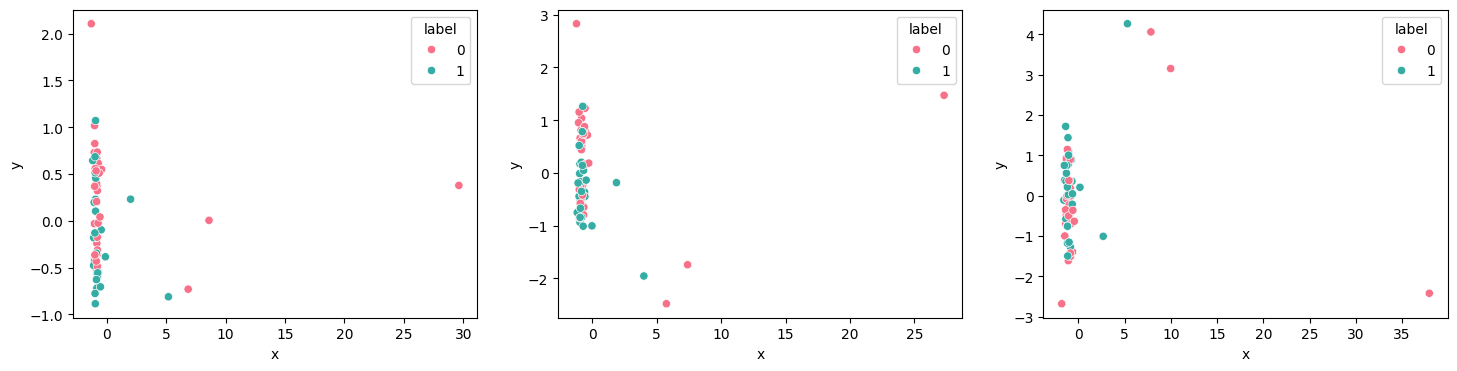

In [ ]:
# Total layers in the model
num_hidden_layers = model.config.num_hidden_layers

# Visualize all layers
layers_to_visualize = list(range(num_hidden_layers))

# Visualize specific layers
layers_to_visualize = [0, num_hidden_layers // 2, num_hidden_layers - 1]  # First, middle, and last

# Use PCA for dimensionality reduction
visualize_layerwise_embeddings(
    hidden_states=hidden_states,
    masks=attention_masks,
    labels=labels,
    layers_to_visualize=layers_to_visualize,
    dim_reducer=pca
)

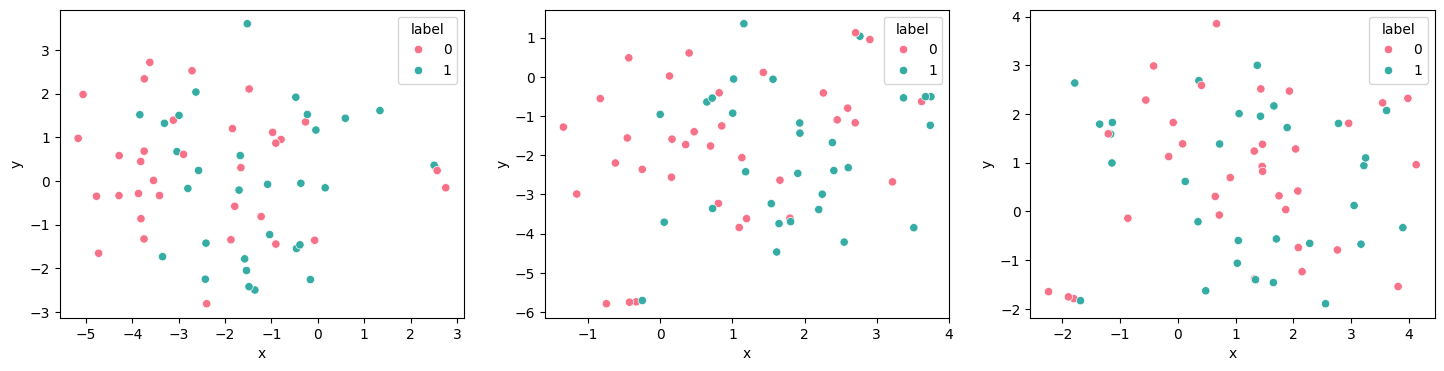

In [ ]:
# Use tSNE for dimensionality reduction
visualize_layerwise_embeddings(
    hidden_states=hidden_states,
    masks=attention_masks,
    labels=labels,
    layers_to_visualize=layers_to_visualize,
    dim_reducer=tsne
)

### Discussion of key points

- The PCA and t-SNE had similar results for the visualization of the embeddings?
- Looking at the best result, this transformer can be used as a Zero-shot* model for this task?


* Zero-shot is the usage a model for a new task without any new traning.

No, the PCA and t-SNE lead to very different results for visualization.
We don't think this transformer is good without a fine tuning in the final layers because we can see that some points are not well separated. With that in mind, we can conclude that the model needs further specialization in this task in order to perform a better classification of the reviews.

## Cluster the latent space (2.5 points).

1. Choose a clustering method (e.g., k-means, hierarchical clustering, DBSCAN) to apply in the dataset. Experiment with different parameter settings for each method (e.g., number of clusters in k-means).

2. Evaluate the performance of each clustering method in terms of its ability to discriminate between the known classes. You can use clustering method but in the end of the dayu I want you to see the proportions of each class in each cluster.

3. Analyze the results for potential outliers. Utilize techniques like DBSCAN or distance-based outlier detection to identify data points that do not fit well within any cluster or are significantly distant from cluster centers. Just find some examples and try to justify that is a oulier.

In [ ]:
# First, let's prepare the latent space

layer_index = -1  # Choosing the last layer for task-specific information
sentence_representations = torch.div(
    hidden_states[layer_index].sum(dim=1),  # Sum along the sequence length dimension
    attention_masks.sum(dim=1, keepdim=True)  # Normalize by the mask sum
).detach().cpu().numpy()  # Move to CPU and convert to NumPy

In [ ]:
# Performing k-means

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


num_clusters = 2  # 2 clusters for binary classification
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(sentence_representations)

# Check cluster proportions
cluster_df = pd.DataFrame({'Cluster': kmeans_labels, 'True_Label': labels.numpy()})
print(cluster_df.groupby(['Cluster', 'True_Label']).size())

# Measuring how well separated the clusters are
score = silhouette_score(sentence_representations, kmeans_labels)
print(f"Silhouette Score: {score}")

Cluster  True_Label
0        0             29
         1             34
1        1              1
dtype: int64
Silhouette Score: 0.6116270422935486


In [ ]:
# Performing DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(sentence_representations)

# Identify outliers (-1 indicates an outlier)
outliers = dbscan_labels == -1
print(f"Number of outliers: {outliers.sum()}")

# Check if there are at least 2 clusters (excluding outliers)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Compare cluster labels with true labels
results = pd.DataFrame({'Cluster': dbscan_labels, 'True_Label': labels.numpy()})
print(results.groupby(['Cluster', 'True_Label']).size())

# Only calculate silhouette score if there are at least 2 clusters
if n_clusters >= 2:
    # Measuring how well separated the clusters are
    score = silhouette_score(sentence_representations, dbscan_labels)
    print(f"Silhouette Score: {score}")
else:
    print("Silhouette Score cannot be calculated: Less than 2 clusters found.")

    # Print unique labels for debugging
    print(f"Unique labels: {set(dbscan_labels)}")

Number of outliers: 64
Cluster  True_Label
-1       0             29
         1             35
dtype: int64
Silhouette Score cannot be calculated: Less than 2 clusters found.
Unique labels: {-1}


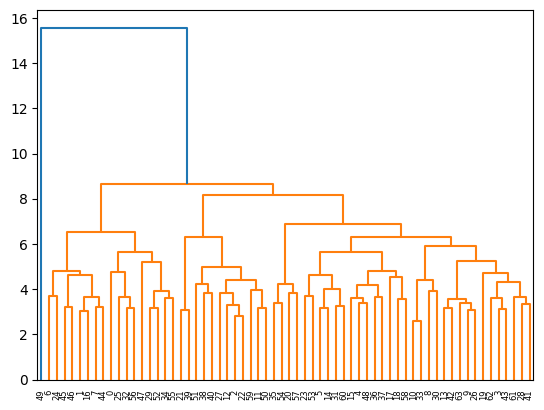

Cluster  True_Label
1        0             29
         1             34
2        1              1
dtype: int64
Silhouette Score: 0.6116270422935486


In [ ]:
# Performing hierarchical clustering

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score


linkage_matrix = linkage(sentence_representations, method='ward')
dendrogram(linkage_matrix)  # Visualize the dendrogram
plt.show()

# Extract flat clusters (2 clusters)
hierarchical_labels = fcluster(linkage_matrix, t=2, criterion='maxclust')

# Compare cluster labels with true labels
results = pd.DataFrame({'Cluster': hierarchical_labels, 'True_Label': labels.numpy()})
print(results.groupby(['Cluster', 'True_Label']).size())

# Measuring how well separated the clusters are
score = silhouette_score(sentence_representations, hierarchical_labels)
print(f"Silhouette Score: {score}")

In [ ]:
# Now, let's take a look at outliers
import numpy as np

# Distance based outlier detection
# Calculate distances to centroids
distances = np.linalg.norm(sentence_representations - kmeans.cluster_centers_[kmeans_labels], axis=1)

outlier_threshold = np.percentile(distances, 95)  # Top 5% as outliers

outliers = distances > outlier_threshold
print(f"Number of outliers: {outliers.sum()}")

outlier_indices = [i for i, is_outlier in enumerate(outliers) if is_outlier]

for i in outlier_indices:
    print(f"Examples of outliers: {x_train[i]}, LABEL: {y_train[i]}")

Number of outliers: 4
Examples of outliers: No movies have grabbed my attention like this one has. You see, I have wanted to watch this movie again for over twenty-five years. The one and only time I saw it was as a teen-ager which may have been the year it was released, 1977.<br /><br />What I do remember of the movie is that it touched those deep-held emotions so profoundly that there is still an overwhelming desire to watch it again. The intrigue this movie provides by the human element of father/son seeking and searching is sure to touch every human soul who watches it. Why this movie has not been brought out of storage and shown as often as many other movies of lesser depth, I do not know.<br /><br />Postscript: Received copy of movie and after watching it again was delighted to see that my memory held true. Rating reflects movie content. Would like to watch this movie on DVD as seeing this 1977 production on a used VHS tape took away from the overall quality., LABEL: True
Example

The clustering does not separate the positive and negative samples well. Ideally, each cluster should mostly consist of samples from one class (either 0 or 1).
In our case, Cluster 1 has a about the same amount of inputs from both classes, and Cluster 2 is very small with only positive samples.

We can also see why the first two outliers are outliers. The first is saying that the film is good, but also explicits that it's not for everyone. The second doesn't even seem like a movie review. However, the last two may be outliers for the amount of text, the third being too long and the forth too short, even though the meaning of both is very clear.

It's also worth mentioning that the DBSCAN is classifying every input as outlier. We tried to change the eps and to normalize the data, but the problem persisted.

## Fine tune the transformer (4.5 points)

In this section you should fine tune the transformer for the sentiment classification task.

To fine tune a model, we need to "freeze" some of their layers. In this case, we will freeze all trainable parameters, except the last part of the model, which is a fully connected layer called "classifier". You can change this approach and test without freezing the entire transformer, but it is not required.

It is important to pay attention to the learning rate and weight decay of the optimizer. Usually, transformers adapt quickly to the problem, and a wrong learning rate (or number of training epochs) can cause an overfitting.

Work with one epoch and smaller batch sizes to test your implementation, as the training can take a longe time.

Remember to test your final model and plot a confusion matrix with the test data.


In [ ]:
# Freeze all layers of the pre trained model
for i,param in enumerate(model.parameters()):
  param.requires_grad = False

# unfreeze the four last layers
for param in model.base_model.encoder.layer[-4:].parameters():
    param.requires_grad = True

In [ ]:
# Define the optmizer, scheduler and criterion

optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']) # https://pytorch.org/docs/stable/optim.html
# scheduler = # Optional: use a scheduler to control the learning rate (besides the weight_decay of the optimizer)
criterion = torch.nn.CrossEntropyLoss()

### Create the train and validation logic

*Tip: The forward method of the BERT transformer expect the "input_ids" and "attention_masks". You can search about the usage of hugging face transformers on the official documentation [here](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/bert#transformers.BertForSequenceClassification)*

In [ ]:
def train(dataloader, model, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in dataloader:
        # Tranfers data to the device
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculates loss
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculates accuracy
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(dataloader)
    train_acc = correct / total

    return train_loss, train_acc

def evaluate(dataloader, model, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            # Transfers data to the device
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculates loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Calculates accuracy
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    valid_loss = total_loss / len(dataloader)
    valid_acc = correct / total

    return valid_loss, valid_acc

### Train and validate

In [ ]:
history = {'train_loss': [], 'valid_loss': [], 'train_acc':[], 'valid_acc':[]}

for epoch in tqdm(range(params['epochs']), desc='Training'):
  train_loss, train_acc = train(train_loader, model, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(valid_loader, model, criterion, device)

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)

  history['valid_loss'].append(valid_loss)
  history['valid_acc'].append(valid_acc)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# prints the max value in train_acc
print(max(history['train_acc']))

# prints the max value in valid_acc
print(max(history['valid_acc']))

0.8074186991869918
0.8024


## Visualize transformer embeddings again (1 point)

Use the same logic previously used in the first part of this task to visualize the fine tunned embeddings of the transformer (with PCA and t-SNE).

In [ ]:
# Obter os estados ocultos (hidden states) do modelo fine-tuned
def extract_hidden_states(dataloader, model, device):
    model.eval()
    all_hidden_states = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass para obter os hidden states
            outputs = model(input_ids=inputs, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # Lista de estados ocultos (uma para cada camada)

            # Salvar o último estado oculto para visualização
            all_hidden_states.append(hidden_states[-1].detach().cpu())  # Use a última camada, por exemplo
            all_labels.append(labels.cpu())

    # Concatena todos os batches
    return torch.cat(all_hidden_states), torch.cat(all_labels)

# Visualizar embeddings
def visualize_embeddings(embeddings, labels, reducer, title="Embeddings Visualization"):
    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Class")
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Extração e visualização
hidden_states, labels = extract_hidden_states(test_loader, model, device)
hidden_states = hidden_states.mean(dim=1).numpy()  # Opcional: média ao longo do tempo (reduzindo sequências)
labels = labels.numpy()

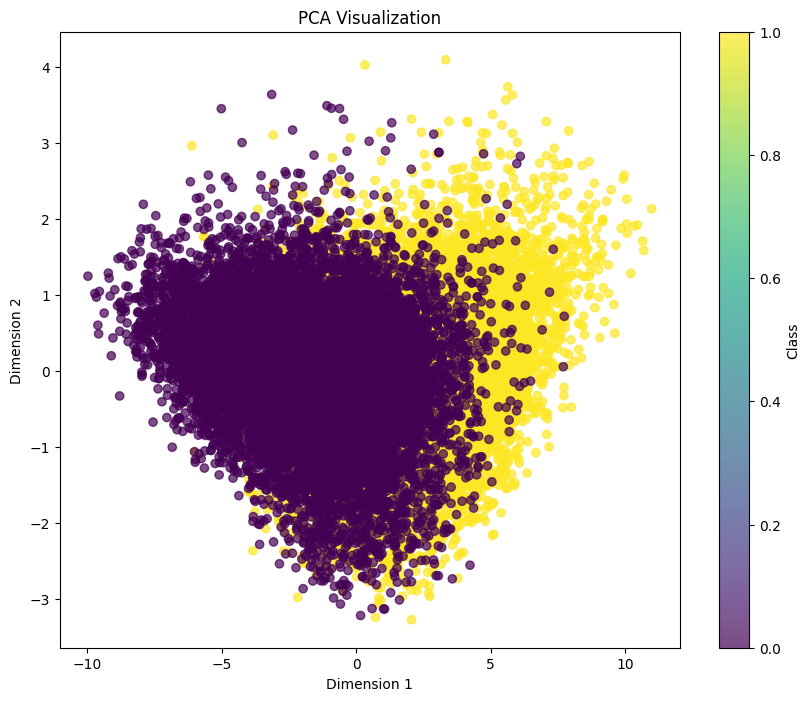

In [ ]:
# PCA visualization
visualize_embeddings(hidden_states, labels, reducer=pca, title="PCA Visualization")

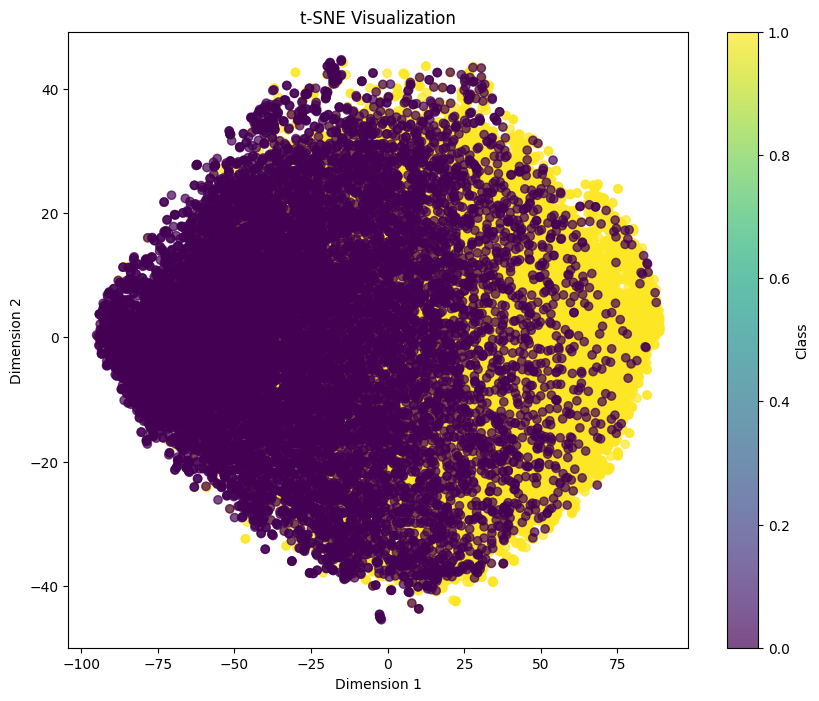

In [ ]:
# t-SNE visualization
visualize_embeddings(hidden_states, labels, reducer=tsne, title="t-SNE Visualization")

### Discussion of key points

- The fine tunning was able to improve the embedding visualization?


Yes, the embedding visualization was improved. We can see in both PCA and t-SNE graphics the majority of the blue points are in the left side, and the majority of the yellow points are in the right side. However, the clusters still have a significantly overlapping, probably because the accuracy of the model isn't that high (it's just 80%).

## Deadline

Friday, June 28, 11:59 pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- June 29, 11:59 pm : grade * 0.75
- June 30, 11:59 pm : grade * 0.5
- July 01, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.